# Installing packages

In [2]:
!pip install simpletransformers
!pip install tensorboardx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:

!pip install ipywidgets
!pip install nltk
!jupyter nbextension enable --py widgetsnbextension

!pip install tensorboardx
!pip install transformers
!pip install sentencepiece



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Fetch Don't Patronize Me! data manager module

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

from collections import Counter
from urllib import request

import pandas as pd
import torch


module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))


# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [6]:
# from dont_patronize_me import DontPatronizeMe

# dpm = DontPatronizeMe('.', '.')
# dpm.load_task1()

from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.

#Use this if running on colab
dpm = DontPatronizeMe('/content/drive/MyDrive/NLPClassification_40', None)
dpm.load_task1()

#Use this if not running on colab
# dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')

# Load datasets

In [31]:
# Extract the training and development data set from cv file to save time

# Thiis is the original dataset
train_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/train_df_.csv')
# test_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/test_df_.csv')

# # This is the upsampled augmented dataset
# train_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/back_translations_german_french_old.csv')
test_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/dev_task1.csv')

submission_test_df = pd.read_csv('/content/drive/MyDrive/NLPClassification_40/task4_test.tsv', sep='\t', names=['par_id', 'art_id', 'keyword', 'country', 'text']).drop('art_id', axis=1)
submission_test_df['length'] = submission_test_df.apply(lambda x: len(x['text']), axis=1)
submission_test_df.rename(columns={"keyword": "community"}, inplace=True)

test_df.head()

,par_id,community,text,label,length
0,4046,hopeless,We also know that they can benefit by receivin...,1,493
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,197
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,74
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,218
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,355


In [ ]:
submission_test_df.head()

,par_id,community,country,text,length
0,t_0,vulnerable,us,"In the meantime , conservatives are working to...",238
1,t_1,women,pk,In most poor households with no education chil...,316
2,t_2,migrant,ca,The real question is not whether immigration i...,203
3,t_3,migrant,gb,"In total , the country 's immigrant population...",90
4,t_4,vulnerable,ca,"Members of the church , which is part of Ken C...",245


In [32]:
train_df.head()

,par_id,text,label,community,length
0,4341,"The scheme saw an estimated 150,000 children f...",1,poor-families,203
1,4136,Durban 's homeless communities reconciliation ...,1,homeless,51
2,10352,The next immediate problem that cropped up was...,1,poor-families,398
3,8279,Far more important than the implications for t...,1,vulnerable,228
4,1164,To strengthen child-sensitive social protectio...,1,poor-families,304


## Feature engineering

In [41]:
# shuffling the training dataset
train_dataframe = train_df.sample(frac=1).reset_index(drop=True)

# Preprocess the data
train_dataframe = pd.get_dummies(train_dataframe, columns=['community']).reset_index(drop=True)
test_set = pd.get_dummies(test_df, columns=['community']).reset_index(drop=True)
submission_set = pd.get_dummies(submission_test_df, columns=['community']).reset_index(drop=True)

# split
# downsample negative instances
pcldf = train_dataframe[train_dataframe.label==1]
npos = len(pcldf)
print(npos)
ratio=4
training_set = pd.concat([pcldf, pcldf, pcldf, train_dataframe[train_dataframe.label==0][:npos * ratio]], ignore_index=True)


# Create train and val sets
# Val_set_copy=test_set.copy()

Val_set_copy=pd.concat([test_set[test_set.label==0][:300],test_set[test_set.label==1][:300]], ignore_index=True)
Val_set_copy=Val_set_copy.sample(frac=1).reset_index(drop=True)
val_set=Val_set_copy




#creating the validation set
# val_pcl_size = int(npos * 0.15)
# val_pcldf = pcldf[-val_pcl_size:].reset_index(drop=True)
# val_set = pd.concat([val_pcldf, train_dataframe[train_dataframe.label==0][npos * ratio: npos * ratio + val_pcl_size * 3]], ignore_index=True)



#additional inputs to the model
community_features=[]
community_features.extend([column for column in training_set.columns if column.startswith('community_')])




794


In [42]:
train_size, train_pcl,train_non_pcl = len(training_set), len(training_set[training_set.label==1]),len(training_set[training_set.label==0])
val_size, val_pcl = len(val_set), len(val_set[val_set.label==1])
test_size, test_pcl = len(test_set), len(test_set[test_set.label==1])
sub_size = len(submission_test_df)

print(f"Training set size: {train_size}. PCL class count : {train_pcl}. Non PCL class count= {train_non_pcl}")
print(f"Validation set size: {val_size}. PCL class count: {val_pcl}")
print(f"Test set size: {test_size}. PCL class count: {test_pcl}")
print(f"Submission test set size: {sub_size}")

Training set size: 5558. PCL class count : 2382. Non PCL class count= 3176
Validation set size: 499. PCL class count: 199
Test set size: 2094. PCL class count: 199
Submission test set size: 3832


# Model creation

In [43]:
import numpy as np
import pandas as pd
import transformers
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torch.optim import AdamW, Adam

import random
import os
from urllib import request

#Imports for Transformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
from transformers import BertModel, BertConfig, BertTokenizer, BertPreTrainedModel
from transformers import Trainer, TrainingArguments, TrainerCallback
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaTokenizerFast, RobertaPreTrainedModel, RobertaForSequenceClassification

!mkdir ref res

mkdir: cannot create directory ‘ref’: File exists
mkdir: cannot create directory ‘res’: File exists


In [44]:
class CustomDataset(Dataset):

    def __init__(self, tokenizer, input_set, include_community=False):
        self.tokenizer = tokenizer
        self.texts = input_set['text']
        self.labels = input_set['label']

        self.include_community = include_community
        
        if self.include_community:
            self.community_labels = [torch.tensor(e) for e in input_set[community_features].values]
        
    def collate_fn(self, batch):
        texts = []
        labels = []
        for sample in batch:
            texts.append(sample['text'])
            labels.append(sample['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        encodings['label'] =  torch.tensor(labels)

        if self.include_community:
            community_label = []
            for sample in batch:
                community_label.append(sample['community_label'])
            encodings['community_label'] = torch.vstack(community_label)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {
            'text': self.texts[idx],
            'label': self.labels[idx]
        }

        if self.include_community:
            item['community_label'] = self.community_labels[idx]

        return item


In [45]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight


class RobertaCustom(RobertaPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.config = config

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),

            torch.nn.Linear(config.hidden_size + len(community_features), config.hidden_size + len(community_features)),
            nn.Tanh(),
            torch.nn.Dropout(0.5),

            torch.nn.Linear(config.hidden_size + len(community_features), 2)
        )

        self.post_init()

    def forward(self, community_label, input_ids=None, **kwargs):
        outputs = self.roberta(input_ids, **kwargs)

        embeddings = outputs[0][:, 0, :]
        concat = torch.cat((embeddings, community_label), dim=-1)

        return self.classifier(concat.float())


class TrainerCustom(Trainer):
    def compute_loss(self, model, inputs):

        # weight_dict = {0:1.0, 1:self.pos_weight}
        # weights = compute_class_weight(weight_dict, classes=np.unique(training_set.label), y=training_set.label)
        # loss = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).cuda())

        loss = nn.CrossEntropyLoss()

        label = inputs.pop('label')
        logits = model(**inputs)

        return loss(logits.view(-1, 2), label.view(-1))

    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=8, shuffle=True, collate_fn=self.train_dataset.collate_fn)


class CustomLossCallback(TrainerCallback):
    def __init__(self, val_dataset, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.train_losses = []
        self.val_losses = []
        self.f1_scores = []

        self.val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=val_dataset.collate_fn)

    def on_epoch_end(self, args, state, control, **kwargs):
        model = kwargs['model']
        loss = nn.CrossEntropyLoss()

        self.train_losses.append(state.log_history[-1]['loss'])
        val_losses = []
        preds = []
        labels = []
        with torch.no_grad():
            for batch in self.val_loader:
                batch = batch.to(torch.device('cuda'))
                label = batch.pop('label')
                community_label = batch.pop('community_label')
                
                logits = model(community_label, **batch)
                
                val_losses.append(loss(logits.view(-1, 2), label.view(-1)).cpu().numpy())
                
                preds.extend(list(logits.argmax(dim=-1).cpu().numpy()))
                labels.extend(list(label.cpu().numpy()))

        self.val_losses.append(np.mean(val_losses))
        self.f1_scores.append(f1_score(labels, preds, zero_division=0))

        print('Train loss: {}, Val loss: {}, Val F1: {}'.format(self.train_losses[-1], self.val_losses[-1], self.f1_scores[-1]))

# Training

In [46]:
# import torch
# from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig
import gc

gc.collect()
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"

tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaCustom.from_pretrained('roberta-base')
# Modify the hidden layers
# config=RobertaConfig.from_pretrained('roberta-base')
# config.num_hidden_layers=12

# # tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
# tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length = 1024)

# model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=2)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_toke

In [47]:



train_dataset = CustomDataset(tokenizer, training_set, include_community=True)
val_dataset = CustomDataset(tokenizer, val_set, include_community=True)

learning_rates=[3e-5,1e-5,5e-4,5e-5,1e-6]
learning_rate=learning_rates[0]
learning_rate_curve = CustomLossCallback(val_dataset)

num_epochs = 5


training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NLPClassification_40/experiment/PCL',
    logging_steps=50,
    per_device_train_batch_size=8,
    num_train_epochs=num_epochs,
    learning_rate=learning_rate
)

trainer = TrainerCustom(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,                   
    data_collator=train_dataset.collate_fn,
    callbacks=[learning_rate_curve]
)

trainer.train()
# trainer.save_model('/content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5558
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accum

Step,Training Loss
50,0.677200
100,0.622500
150,0.498500
200,0.610900
250,0.491800
300,0.557500
350,0.530800
400,0.437000
450,0.458400
500,0.475200


Saving model checkpoint to /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-500
Configuration saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-500/pytorch_model.bin


Train loss: 0.3814, Val loss: 0.6675059199333191, Val F1: 0.7127071823204421


Saving model checkpoint to /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1000
Configuration saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1000/pytorch_model.bin


Train loss: 0.207, Val loss: 1.0855907201766968, Val F1: 0.6098360655737706


Saving model checkpoint to /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1500
Configuration saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-2000
Configuration saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-2000/config.json
Model weights saved in /content/drive/MyDrive/NLPClassification_40/experiment/PCL/checkpoint-2000/pytorch_model.bin


Train loss: 0.106, Val loss: 1.0093148946762085, Val F1: 0.7645429362880887


KeyboardInterrupt: ignored

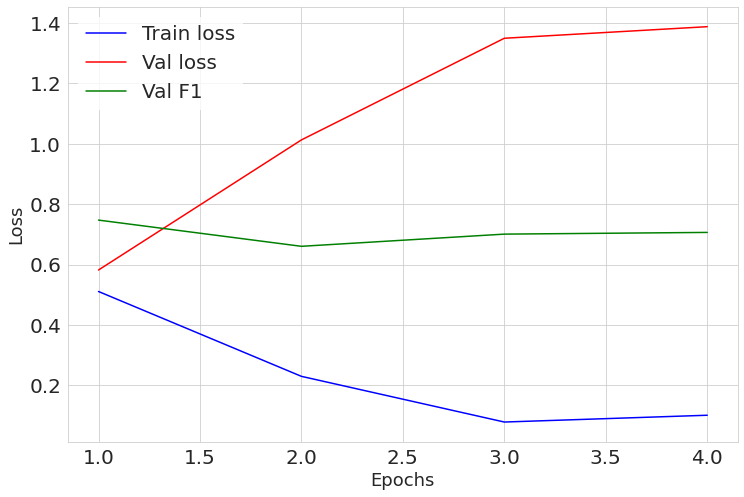

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')  # Set the plot style

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the lines
plt.plot(range(1, num_epochs + 1), learning_rate_curve.train_losses, label="Train loss",color='blue')
plt.plot(range(1, num_epochs + 1), learning_rate_curve.val_losses, label="Val loss",color='red')
plt.plot(range(1, num_epochs + 1), learning_rate_curve.f1_scores, label="Val F1",color='green')

# Set the x and y labels and font sizes
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# Add a legend and customize it
plt.legend(loc='best', fontsize=50)
legend = plt.legend(fontsize=20)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

plt.show()


# Dev set evaluation

In [ ]:
# Uncomment if model's already trained

model_name = '/content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/'
model = RobertaCustom.from_pretrained(model_name).to('cuda')


loading configuration file /content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaCustom"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file /content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaCustom.

All the 

In [ ]:
test_dataset = CustomDataset(tokenizer, test_set, include_community=True)

# test_dataset_short = CustomDataset(tokenizer, test_set[test_set['length'] >= 0].reset_index(drop=True), include_community=True)
test_loader = DataLoader(test_dataset , batch_size=32, collate_fn=test_dataset.collate_fn)

tot_preds = []
labels = []
with torch.no_grad():
    model.eval()
    for batch in (test_loader):
        batch = batch.to(torch.device('cuda'))
        label = batch.pop('label')
        community_label = batch.pop('community_label')
        logits = model(community_label, **batch)
        
        preds = logits.argmax(axis=1)
        tot_preds.extend(list(preds.cpu().numpy()))
        labels.extend(list(label.cpu().numpy()))

print(Counter(tot_preds))

print(f1_score(labels, tot_preds, zero_division=0))

Counter({0: 1900, 1: 194})
0.5750636132315522


precision: 0.5824742268041238
recall： 0.5678391959798995
f1_score: 0.5750636132315522


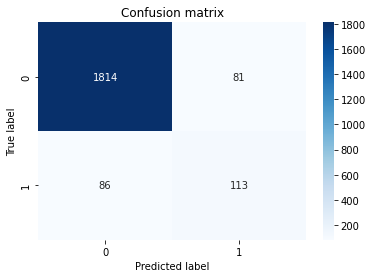

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('precision: ' + str(precision_score(labels, tot_preds)))
print( 'recall： ' + str(recall_score(labels, tot_preds)))
print('f1_score: ' + str(f1_score(labels, tot_preds)))

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, tot_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
add accuracy 

In [ ]:
print(f'Development set length = {len(test_set)}')
print(f'Predictions  length = {len(tot_preds)}')

labels2file([[k] for k in tot_preds], './res/task1_res_dev.txt')
labels2file(test_set.label.apply(lambda x:[x]).tolist(), './ref/task1_ref_dev.txt')

labels2file([[k] for k in tot_preds], './res/task1.txt')
labels2file(test_set.label.apply(lambda x:[x]).tolist(), './ref/task1.txt')

Development set length = 2094
Predictions  length = 2094


In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


In [ ]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python3 evaluation.py . .

In [ ]:
# The scorer generated a results file called "scores.txt". 
# We can now see the performance of a random baseline on the training set.
!cat scores.txt

task1_precision:0.5824742268041238
task1_recall:0.5678391959798995
task1_f1:0.5750636132315522


# Analysis 
## 1. Higher levels of patronizing content

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [ ]:

original_data_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/original_test_set.csv')
original_data_df.head()

,par_id,community,text,label,orig_label,length
0,4046,hopeless,We also know that they can benefit by receivin...,1,3,85
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4,38
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2,16
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,42
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3,70


In [ ]:
original_data_df.value_counts('orig_label')


orig_label
0    1704
1     191
4      92
3      89
2      18
dtype: int64

In [ ]:
original_data_df = pd.get_dummies(original_data_df, columns=['community']).reset_index(drop=True)
original_data_df.head()

,par_id,text,label,orig_label,length,community_disabled,community_homeless,community_hopeless,community_immigrant,community_in-need,community_migrant,community_poor-families,community_refugee,community_vulnerable,community_women
0,4046,We also know that they can benefit by receivin...,1,3,85,0,0,1,0,0,0,0,0,0,0
1,1279,Pope Francis washed and kissed the feet of Mus...,1,4,38,0,0,0,0,0,0,0,1,0,0
2,8330,Many refugees do n't want to be resettled anyw...,1,2,16,0,0,0,0,0,0,0,1,0,0
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,42,0,0,0,0,1,0,0,0,0,0
4,4089,"""In a 90-degree view of his constituency , one...",1,3,70,0,1,0,0,0,0,0,0,0,0


In [ ]:
# original_data_df = original_data_df.sort_values(by=['length'], ascending=True)
# original_data_df.head()

original_data_df=original_data_df[original_data_df['length']>0]
original_data_df.head()

,par_id,text,label,orig_label,length,community_disabled,community_homeless,community_hopeless,community_immigrant,community_in-need,community_migrant,community_poor-families,community_refugee,community_vulnerable,community_women
0,4046,We also know that they can benefit by receivin...,1,3,85,0,0,1,0,0,0,0,0,0,0
1,1279,Pope Francis washed and kissed the feet of Mus...,1,4,38,0,0,0,0,0,0,0,1,0,0
2,8330,Many refugees do n't want to be resettled anyw...,1,2,16,0,0,0,0,0,0,0,1,0,0
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,42,0,0,0,0,1,0,0,0,0,0
4,4089,"""In a 90-degree view of his constituency , one...",1,3,70,0,1,0,0,0,0,0,0,0,0


In [ ]:
original_data_df = original_data_df.sort_values(by=['length'], ascending=False)
original_data_df.head()

,par_id,text,label,orig_label,length,community_disabled,community_homeless,community_hopeless,community_immigrant,community_in-need,community_migrant,community_poor-families,community_refugee,community_vulnerable,community_women
1495,9811,Two goals in the third quarter put the Ballysh...,0,0,272,0,0,0,0,1,0,0,0,0,0
1985,10346,"""A Nigerian-American , Alexis Okeowo , shoulde...",0,0,188,0,0,0,1,0,0,0,0,0,0
2081,10453,"""Provincial Minister Schools Education Rana Ma...",0,1,177,0,0,0,0,0,0,1,0,0,0
17,6189,"""Our country is in need of serious change . We...",1,4,175,0,0,0,0,0,0,0,0,0,1
23,1208,It is written in Ecclessiastes in the Bible th...,1,4,165,0,0,0,0,0,0,0,0,1,0


In [ ]:
label_0df = pd.DataFrame(original_data_df[original_data_df.orig_label==0]).reset_index(drop=True)
label_1df = pd.DataFrame(original_data_df[original_data_df.orig_label==1]).reset_index(drop=True)
label_2df = pd.DataFrame(original_data_df[original_data_df.orig_label==2]).reset_index(drop=True)
label_3df = pd.DataFrame(original_data_df[original_data_df.orig_label==3]).reset_index(drop=True)
label_4df = pd.DataFrame(original_data_df[original_data_df.orig_label==4]).reset_index(drop=True)

labels_datasets=[label_0df,label_1df,label_2df,label_3df,label_4df]
label_names=['Class 0','Class 1','Class 2','Class 3','Class 4']


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class =  Class 0
Counter({0: 1651, 1: 52})
Accuracy:  0.9694656488549618
precision: 0.0
recall： 0.0
f1_score: 0.0


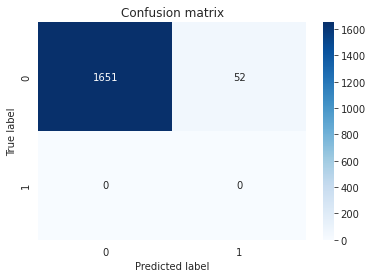

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class =  Class 1
Counter({0: 162, 1: 29})
Accuracy:  0.8481675392670157
precision: 0.0
recall： 0.0
f1_score: 0.0


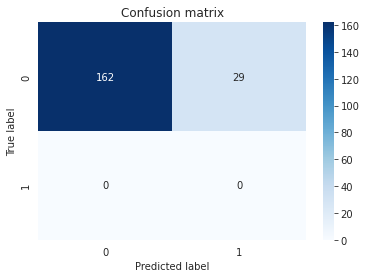

Class =  Class 2
Counter({0: 14, 1: 4})
Accuracy:  0.2222222222222222
precision: 1.0
recall： 0.2222222222222222
f1_score: 0.3636363636363636


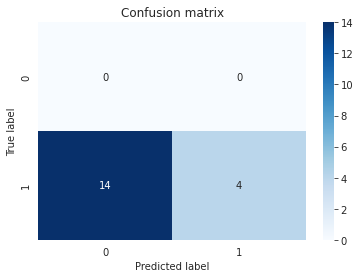

Class =  Class 3
Counter({1: 46, 0: 43})
Accuracy:  0.5168539325842697
precision: 1.0
recall： 0.5168539325842697
f1_score: 0.6814814814814816


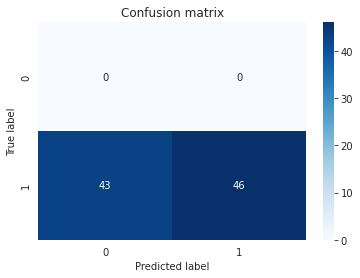

Class =  Class 4
Counter({1: 63, 0: 29})
Accuracy:  0.6847826086956522
precision: 1.0
recall： 0.6847826086956522
f1_score: 0.8129032258064516


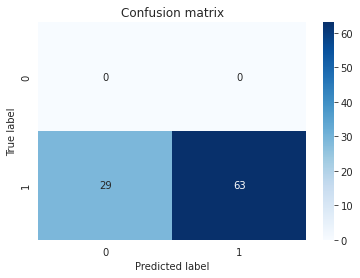

In [ ]:
results_analysis_1=[]
for num,label_dataset in enumerate(labels_datasets):
  test_dataset = CustomDataset(tokenizer, label_dataset, include_community=True)
  test_loader = DataLoader(test_dataset , batch_size=32, collate_fn=test_dataset.collate_fn)

  tot_preds = []
  labels = []
  with torch.no_grad():
      model.eval()
      for batch in (test_loader):
          batch = batch.to(torch.device('cuda'))
          label = batch.pop('label')
          community_label = batch.pop('community_label')
          logits = model(community_label, **batch)
          
          preds = logits.argmax(axis=1)
          tot_preds.extend(list(preds.cpu().numpy()))
          labels.extend(list(label.cpu().numpy()))

  # Calculate the evaluation metrics
  accuracy = accuracy_score(labels, tot_preds)
  precision = precision_score(labels, tot_preds)
  recall = recall_score(labels, tot_preds)
  f1 = f1_score(labels, tot_preds)

  # Append the results to the list
  results_analysis_1.append({
      'Class': label_names[num],
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  })

  print('Class = ',label_names[num])  
  print(Counter(tot_preds))
  print('Accuracy: ',accuracy)
  print('precision: ' + str(precision))
  print( 'recall： ' + str(recall))
  print('f1_score: ' + str(f1))

  # Display the confusion matrix
  import seaborn as sns
  import matplotlib.pyplot as plt
  cm = confusion_matrix(labels, tot_preds)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# Create a pandas dataframe from the results list
df_results_analysis_1 = pd.DataFrame(results_analysis_1)


In [ ]:
df_results_analysis_1

,Class,accuracy,precision,recall,f1_score
0,Class 0,0.969466,0.0,0.000000,0.000000
1,Class 1,0.848168,0.0,0.000000,0.000000
2,Class 2,0.222222,1.0,0.222222,0.363636
3,Class 3,0.516854,1.0,0.516854,0.681481
4,Class 4,0.684783,1.0,0.684783,0.812903


## 2. Length vs model performance

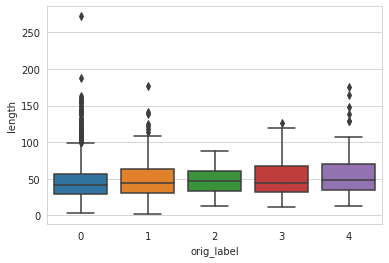

In [ ]:
# Create a box plot of the length of sentences
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.boxplot(x='orig_label', y='length', data=original_data_df)
plt.show()

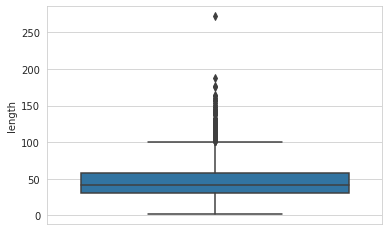

In [ ]:
# Create a box plot of the length of sentences
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.boxplot( y='length', data=original_data_df)
plt.show()

In [ ]:
original_data_df.length.describe()

count    2093.000000
mean       47.434305
std        26.584979
min         2.000000
25%        30.000000
50%        41.000000
75%        58.000000
max       272.000000
Name: length, dtype: float64

In [ ]:
lower=np.percentile(original_data_df.length, 25)
mean=np.percentile(original_data_df.length, 50)
upper=np.percentile(original_data_df.length, 75)

Upper_whisker_limit=upper+1.5*(upper-lower)
Upper_whisker_limit

100.0

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


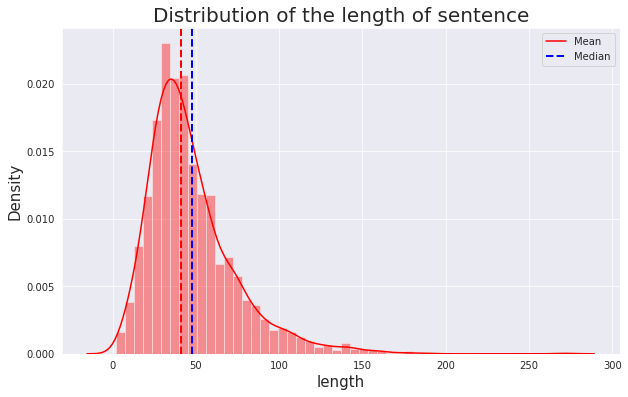

In [ ]:
# Plot a fancy colorful histogram distribution of the similarity scores
# Show the mean and median of the similarity scores on the plot. Show the actual value of the mean and median on the plot.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.distplot(original_data_df["length"], color="red")
plt.axvline(original_data_df["length"].mean(), color="blue", linestyle="dashed", linewidth=2)
plt.axvline(original_data_df["length"].median(), color="red", linestyle="dashed", linewidth=2)


plt.title("Distribution of the length of sentence", fontsize=20)
plt.xlabel("length", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend({"Mean": original_data_df["length"].mean(),
            "Median": original_data_df["length"].median(),
            })


plt.show()

In [ ]:
Pecentile_25 = pd.DataFrame(original_data_df.loc[original_data_df.length < lower]).reset_index(drop=True)
Pecentile_50 = pd.DataFrame(original_data_df.loc[(original_data_df.length > lower) & (original_data_df.length < mean)]).reset_index(drop=True)
Pecentile_75 = pd.DataFrame(original_data_df.loc[(original_data_df.length > mean) & (original_data_df.length < upper)]).reset_index(drop=True)
Pecentile_upper = pd.DataFrame(original_data_df.loc[(original_data_df.length > upper) & (original_data_df.length < Upper_whisker_limit)]).reset_index(drop=True)
Pecentile_outliers = pd.DataFrame(original_data_df.loc[original_data_df.length > upper]).reset_index(drop=True)



In [ ]:
percentile_datasets=[Pecentile_25,Pecentile_50,Pecentile_75,Pecentile_upper,Pecentile_outliers]
percentile_names=['region_25','region_50','region_75','region_upper','region_outliers']

Class =  region_25
Counter({0: 476, 1: 39})
Accuracy:  0.9398058252427185
precision: 0.48717948717948717
recall： 0.6333333333333333
f1_score: 0.5507246376811593


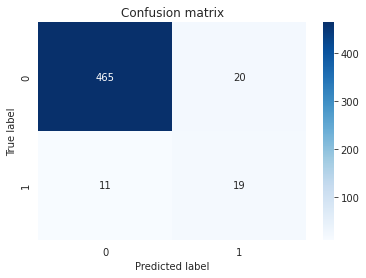

Class =  region_50
Counter({0: 406, 1: 45})
Accuracy:  0.9246119733924612
precision: 0.6
recall： 0.627906976744186
f1_score: 0.6136363636363636


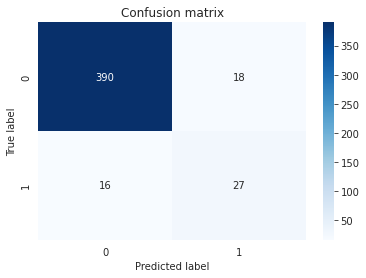

Class =  region_75
Counter({0: 460, 1: 35})
Accuracy:  0.9373737373737374
precision: 0.6285714285714286
recall： 0.55
f1_score: 0.5866666666666667


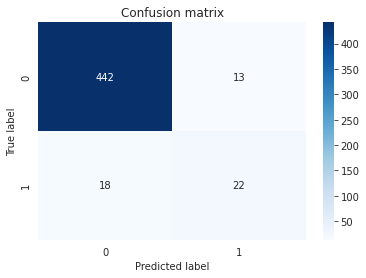

Class =  region_upper
Counter({0: 370, 1: 44})
Accuracy:  0.8743961352657005
precision: 0.5454545454545454
recall： 0.42857142857142855
f1_score: 0.4799999999999999


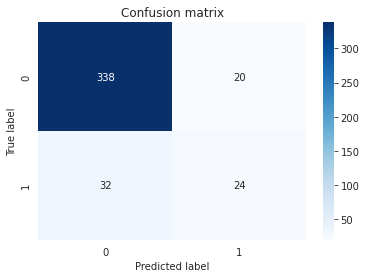

Class =  region_outliers
Counter({0: 463, 1: 59})
Accuracy:  0.8793103448275862
precision: 0.559322033898305
recall： 0.4714285714285714
f1_score: 0.5116279069767442


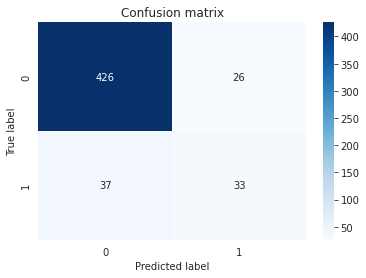

In [ ]:
results_analysis_2=[]
for num,percentile_dataset in enumerate(percentile_datasets):
  test_dataset = CustomDataset(tokenizer, percentile_dataset, include_community=True)
  test_loader = DataLoader(test_dataset , batch_size=32, collate_fn=test_dataset.collate_fn)

  tot_preds = []
  labels = []
  with torch.no_grad():
      model.eval()
      for batch in (test_loader):
          batch = batch.to(torch.device('cuda'))
          label = batch.pop('label')
          community_label = batch.pop('community_label')
          logits = model(community_label, **batch)
          
          preds = logits.argmax(axis=1)
          tot_preds.extend(list(preds.cpu().numpy()))
          labels.extend(list(label.cpu().numpy()))

  # Calculate the evaluation metrics
  accuracy = accuracy_score(labels, tot_preds)
  precision = precision_score(labels, tot_preds)
  recall = recall_score(labels, tot_preds)
  f1 = f1_score(labels, tot_preds)

  # Append the results to the list
  results_analysis_2.append({
      'Class': percentile_names[num],
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  })

  print('Class = ',percentile_names[num])  
  print(Counter(tot_preds))
  print('Accuracy: ',accuracy)
  print('precision: ' + str(precision))
  print( 'recall： ' + str(recall))
  print('f1_score: ' + str(f1))

  # Display the confusion matrix
  import seaborn as sns
  import matplotlib.pyplot as plt
  cm = confusion_matrix(labels, tot_preds)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# Create a pandas dataframe from the results list
df_results_analysis_2 = pd.DataFrame(results_analysis_2)


In [ ]:
df_results_analysis_2

,Class,accuracy,precision,recall,f1_score
0,region_25,0.939806,0.487179,0.633333,0.550725
1,region_50,0.924612,0.600000,0.627907,0.613636
2,region_75,0.937374,0.628571,0.550000,0.586667
3,region_upper,0.874396,0.545455,0.428571,0.480000
4,region_outliers,0.879310,0.559322,0.471429,0.511628


# 3. Catergories vs model performance

###  3.1. First use the trained model to predict on each community type

In [ ]:
categories_data_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/original_test_set.csv')
categories_data_df.head()

,par_id,community,text,label,length,orig_label
0,4046,hopeless,We also know that they can benefit by receivin...,1,493,3
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,197,4
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,74,2
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,218,4
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,355,3


In [ ]:
category_list = list(set(categories_data_df.community.tolist()))
print(category_list)

['hopeless', 'migrant', 'immigrant', 'homeless', 'disabled', 'poor-families', 'in-need', 'refugee', 'vulnerable', 'women']


Community =  hopeless
Counter({0: 190, 1: 27})
Accuracy:  0.8847926267281107
precision: 0.5185185185185185
recall： 0.5384615384615384
f1_score: 0.5283018867924528


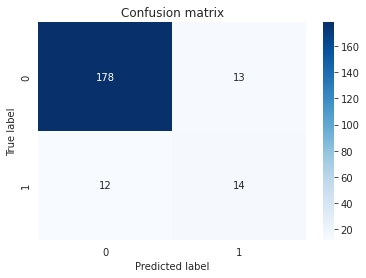

Community =  migrant
Counter({0: 202, 1: 4})
Accuracy:  0.9854368932038835
precision: 0.75
recall： 0.6
f1_score: 0.6666666666666665


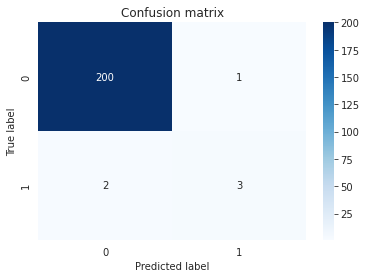

Community =  immigrant
Counter({0: 215, 1: 3})
Accuracy:  0.9724770642201835
precision: 0.6666666666666666
recall： 0.2857142857142857
f1_score: 0.4


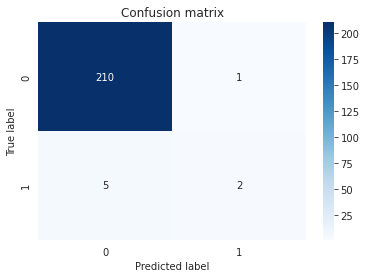

Community =  homeless
Counter({0: 181, 1: 31})
Accuracy:  0.8679245283018868
precision: 0.5161290322580645
recall： 0.5517241379310345
f1_score: 0.5333333333333333


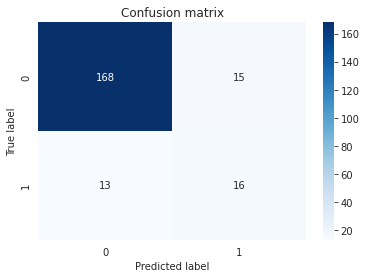

Community =  disabled
Counter({0: 184, 1: 10})
Accuracy:  0.9484536082474226
precision: 0.7
recall： 0.5
f1_score: 0.5833333333333334


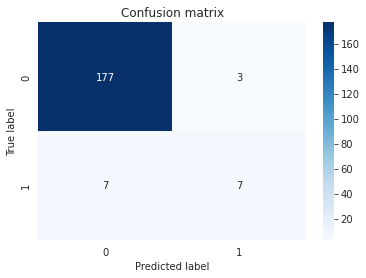

Community =  poor-families
Counter({0: 158, 1: 32})
Accuracy:  0.8421052631578947
precision: 0.625
recall： 0.5263157894736842
f1_score: 0.5714285714285714


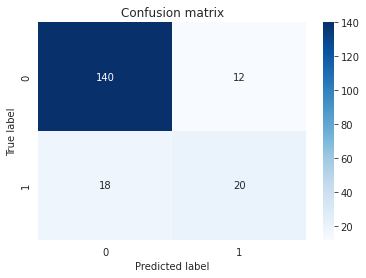

Community =  in-need
Counter({0: 182, 1: 44})
Accuracy:  0.915929203539823
precision: 0.6590909090909091
recall： 0.8787878787878788
f1_score: 0.7532467532467532


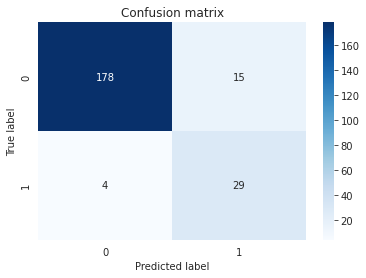

Community =  refugee
Counter({0: 172, 1: 16})
Accuracy:  0.9202127659574468
precision: 0.4375
recall： 0.5384615384615384
f1_score: 0.4827586206896552


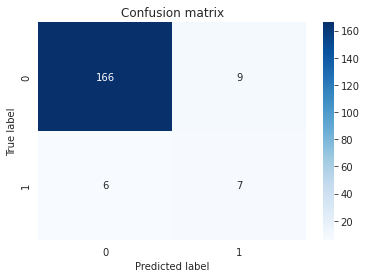

Community =  vulnerable
Counter({0: 188, 1: 21})
Accuracy:  0.9282296650717703
precision: 0.6190476190476191
recall： 0.65
f1_score: 0.6341463414634146


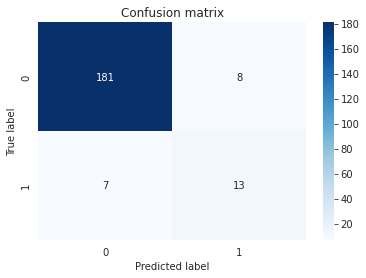

Community =  women
Counter({0: 227, 1: 6})
Accuracy:  0.9313304721030042
precision: 0.3333333333333333
recall： 0.14285714285714285
f1_score: 0.2


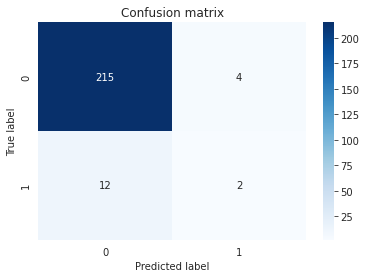

In [ ]:
results_analysis_3=[]

for num,category in enumerate(category_list):
  category_df=original_data_df[original_data_df['community_'+category_list[num]]==1].reset_index(drop=True)
  test_dataset = CustomDataset(tokenizer, category_df, include_community=True)
  test_loader = DataLoader(test_dataset , batch_size=32, collate_fn=test_dataset.collate_fn)

  tot_preds = []
  labels = []
  with torch.no_grad():
      model.eval()
      for batch in (test_loader):
          batch = batch.to(torch.device('cuda'))
          label = batch.pop('label')
          community_label = batch.pop('community_label')
          logits = model(community_label, **batch)
          
          preds = logits.argmax(axis=1)
          tot_preds.extend(list(preds.cpu().numpy()))
          labels.extend(list(label.cpu().numpy()))

  # Calculate the evaluation metrics
  accuracy = accuracy_score(labels, tot_preds)
  precision = precision_score(labels, tot_preds)
  recall = recall_score(labels, tot_preds)
  f1 = f1_score(labels, tot_preds)

  # Append the results to the list
  results_analysis_3.append({
      'Community': category_list[num],
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  })

  print('Community = ',category_list[num])  
  print(Counter(tot_preds))
  print('Accuracy: ',accuracy)
  print('precision: ' + str(precision))
  print( 'recall： ' + str(recall))
  print('f1_score: ' + str(f1))

  # Display the confusion matrix
  import seaborn as sns
  import matplotlib.pyplot as plt
  cm = confusion_matrix(labels, tot_preds)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
df_results_analysis_3 = pd.DataFrame(results_analysis_3)


In [ ]:
df_results_analysis_3

,Community,accuracy,precision,recall,f1_score
0,hopeless,0.884793,0.518519,0.538462,0.528302
1,migrant,0.985437,0.750000,0.600000,0.666667
2,immigrant,0.972477,0.666667,0.285714,0.400000
3,homeless,0.867925,0.516129,0.551724,0.533333
4,disabled,0.948454,0.700000,0.500000,0.583333
5,poor-families,0.842105,0.625000,0.526316,0.571429
6,in-need,0.915929,0.659091,0.878788,0.753247
7,refugee,0.920213,0.437500,0.538462,0.482759
8,vulnerable,0.928230,0.619048,0.650000,0.634146
9,women,0.931330,0.333333,0.142857,0.200000


In [ ]:
categories_data_df.value_counts('community')

community
women            233
in-need          226
immigrant        218
hopeless         217
homeless         212
vulnerable       209
migrant          207
disabled         194
poor-families    190
refugee          188
dtype: int64

# Submission

In [ ]:
submission_set['label'] = -1

submission_dataset = CustomDataset(tokenizer, submission_set, include_community=True)
submission_loader = DataLoader(submission_dataset, batch_size=32, collate_fn=submission_dataset.collate_fn)

tot_preds = []
with torch.no_grad():
    model.eval()
    for batch in (submission_loader):
        batch = batch.to(torch.device('cuda'))
        labels = batch.pop('label')
        community_label = batch.pop('community_label')
        logits = model(community_label, **batch)
        
        preds = logits.argmax(axis=1)
        tot_preds.extend(list(preds.cpu().numpy()))


labels2file([[k] for k in tot_preds], './task1_test.txt')



In [ ]:
[[k] for k in tot_preds]

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]